In [27]:
import ast
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix
import pandas as pd
import tensorflow as tf
import os
import re

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

# Ground-truth nonlinear effect functions (assumed to be defined elsewhere in your code)
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def read_with_var_name(var_name, var_type, save_path, scenario_index):
    if var_type == 'npy':
        return np.load(f"{save_path}/{var_name}_{scenario_index}.npy")
    if var_type == 'keras':
        return tf.keras.models.load_model(f"{save_path}/{var_name}_{scenario_index}.keras")
    if var_type == 'df':
        return pd.read_csv(f"{save_path}/{var_name}_{scenario_index}.csv")

def transform_param_eta(eta_str):
    """
    Transforms an R-style spline term like:
      s(Z1, k = 15, bs = "cr")
    into a Python-style term:
      spline(Z1, bs='bs', df=14)
    Assumes that df = k - 1.
    Also transforms "(Intercept)" to "Intercept".
    """
    # Replace "(Intercept)" with "Intercept"
    eta_str = eta_str.replace("(Intercept)", "Intercept")
    
    pattern = r"s\((Z\d),\s*k\s*=\s*(\d+),\s*bs\s*=\s*['\"]cr['\"]\)"
    match = re.match(pattern, eta_str)
    if match:
        var = match.group(1)
        k_val = int(match.group(2))
        df_val = k_val - 1
        return f"spline({var}, bs='bs', df={df_val})"
    else:
        # Return the original string if it doesn't match the pattern.
        return eta_str

def convert_r_value_string(value_str):
    """
    Converts an R-style value string like:
      "c(-0.957615792751312)"
    or
      "c(0.00564139103516936, 0.0298147071152925, ...)"
    into a Python-style list string "[...]" so that it can be parsed.
    """
    value_str = value_str.strip()
    
    if value_str.startswith("c(") and value_str.endswith(")"):
        # Remove the leading "c(" and trailing ")"
        inner = value_str[2:-1].strip()
        # Replace commas with spaces so np.fromstring can parse it correctly.
        inner = inner.replace(",", " ")
        return f"[{inner}]"
    else:
        return value_str


In [59]:
def plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                          python_estimate_path, r_estimate_path, combined=True, bias_reconstruct=False):
    """
    Plots the estimated spline curves for Z1 and Z2.
    
    If combined=True (default), both Python (blue) and R (red) curves are overlaid
    in a single figure with two subplots (one for Z1, one for Z2).
    
    If combined=False, two separate figures are generated:
      - One for Python results (Z1 and Z2 subplots in blue)
      - One for R results (Z1 and Z2 subplots in red)
    """
    z1_grid = np.linspace(0, 1, 100)
    z2_grid = np.linspace(0, 1, 100)
    
    # Combined mode: one figure with two subplots
    if combined:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        for rep in range(n_reps):
            scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
            
            # Python estimates (blue)
            try:
                coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
            except FileNotFoundError:
                print(f"Python file not found for {scenario_index}.")
                coeff_dict_py = None
            
            if coeff_dict_py is not None:
                # For Z1
                term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
                df_Z1_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z1]
                if not df_Z1_py.empty:
                    coeff_str = df_Z1_py['value'].iloc[0]
                    estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                    if bias_reconstruct:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                                {"x": z1_grid}, return_type='dataframe')
                    else:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                                {"x": z1_grid}, return_type='dataframe')
                        if 'Intercept' in spline_basis.columns:
                            spline_basis = spline_basis.drop('Intercept', axis=1)
                    B = spline_basis.to_numpy()
                    f_est = B.dot(estimated_coeffs)
                    axes[0].plot(z1_grid, f_est, color='blue', alpha=0.2, lw=1,
                                 zorder=1, label="Python" if rep == 0 else "")
                # For Z2
                term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
                df_Z2_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z2]
                if not df_Z2_py.empty:
                    coeff_str = df_Z2_py['value'].iloc[0]
                    estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                    if bias_reconstruct:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                            {"x": z2_grid}, return_type='dataframe')
                    else:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                                {"x": z2_grid}, return_type='dataframe')
                        if 'Intercept' in spline_basis.columns:
                            spline_basis = spline_basis.drop('Intercept', axis=1)
                    B = spline_basis.to_numpy()
                    f_est = B.dot(estimated_coeffs)
                    axes[1].plot(z2_grid, f_est, color='blue', alpha=0.2, lw=1,
                                 zorder=1, label="Python" if rep == 0 else "")
            
            # R estimates (red)
            try:
                coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
                coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)

            except FileNotFoundError:
                print(f"R file not found for {scenario_index}.")
                coeff_dict_r = None
            
            if coeff_dict_r is not None:
                # For Z1
                term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
                df_Z1_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z1]
                if not df_Z1_r.empty:
                    coeff_str = df_Z1_r['value'].iloc[0]
                    coeff_str = convert_r_value_string(coeff_str)
                    estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                    if bias_reconstruct:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                            {"x": z1_grid}, return_type='dataframe')
                    else:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                                {"x": z1_grid}, return_type='dataframe')
                        if 'Intercept' in spline_basis.columns:
                            spline_basis = spline_basis.drop('Intercept', axis=1)
                    B = spline_basis.to_numpy()
                    f_est = B.dot(estimated_coeffs)
                    axes[0].plot(z1_grid, f_est, color='red', alpha=0.2, lw=1,
                                 zorder=1, label="R" if rep == 0 else "")
                # For Z2
                term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
                df_Z2_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z2]
                if not df_Z2_r.empty:
                    coeff_str = df_Z2_r['value'].iloc[0]
                    coeff_str = convert_r_value_string(coeff_str)
                    estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                    if bias_reconstruct:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                            {"x": z2_grid}, return_type='dataframe')
                    else:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                                {"x": z2_grid}, return_type='dataframe')
                        if 'Intercept' in spline_basis.columns:
                            spline_basis = spline_basis.drop('Intercept', axis=1)
                    B = spline_basis.to_numpy()
                    f_est = B.dot(estimated_coeffs)
                    axes[1].plot(z2_grid, f_est, color='red', alpha=0.2, lw=1,
                                 zorder=1, label="R" if rep == 0 else "")
        
        # Overlay true nonlinear effects (black)
        true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
        true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
        axes[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
        axes[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
        axes[0].set_xlabel(r'$Z_1$')
        axes[0].set_ylabel(r'$f_1(Z_1)$')
        axes[0].set_title("Estimated Splines for Z1")
        axes[0].legend()
        axes[1].set_xlabel(r'$Z_2$')
        axes[1].set_ylabel(r'$f_2(Z_2)$')
        axes[1].set_title("Estimated Splines for Z2")
        axes[1].legend()
        plt.tight_layout()
        combined_filename = os.path.join(python_estimate_path, "combined_estimated_splines.png")
        plt.savefig(combined_filename)
        plt.show()
        print(f"Combined figure saved as {combined_filename}")
    
    else:
        # Separate mode: two figures, one for Python and one for R
        # Python figure
        fig_py, axes_py = plt.subplots(1, 2, figsize=(14, 6))
        for rep in range(n_reps):
            scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
            try:
                coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
            except FileNotFoundError:
                print(f"Python file not found for {scenario_index}.")
                continue
            # Z1
            term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
            df_Z1_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z1]
            if not df_Z1_py.empty:
                coeff_str = df_Z1_py['value'].iloc[0]
                estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                if bias_reconstruct:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                        {"x": z1_grid}, return_type='dataframe')
                else:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                            {"x": z1_grid}, return_type='dataframe')
                    if 'Intercept' in spline_basis.columns:
                        spline_basis = spline_basis.drop('Intercept', axis=1)
                B = spline_basis.to_numpy()
                f_est = B.dot(estimated_coeffs)
                axes_py[0].plot(z1_grid, f_est, color='blue', alpha=0.2, lw=1,
                                zorder=1)
            # Z2
            term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
            df_Z2_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z2]
            if not df_Z2_py.empty:
                coeff_str = df_Z2_py['value'].iloc[0]
                estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                if bias_reconstruct:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                    {"x": z2_grid}, return_type='dataframe')
                else:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                            {"x": z2_grid}, return_type='dataframe')
                    if 'Intercept' in spline_basis.columns:
                        spline_basis = spline_basis.drop('Intercept', axis=1)
                B = spline_basis.to_numpy()
                f_est = B.dot(estimated_coeffs)
                axes_py[1].plot(z2_grid, f_est, color='blue', alpha=0.2, lw=1,
                                zorder=1)
        # Overlay true effects
        true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
        true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
        axes_py[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
        axes_py[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
        axes_py[0].set_xlabel(r'$Z_1$')
        axes_py[0].set_ylabel(r'$f_1(Z_1)$')
        axes_py[0].set_title("Python: Estimated Splines for Z1")
        axes_py[0].legend()
        axes_py[1].set_xlabel(r'$Z_2$')
        axes_py[1].set_ylabel(r'$f_2(Z_2)$')
        axes_py[1].set_title("Python: Estimated Splines for Z2")
        axes_py[1].legend()
        plt.tight_layout()
        py_filename = os.path.join(python_estimate_path, "python_estimated_splines.png")
        plt.savefig(py_filename)
        plt.show()
        print(f"Python-only figure saved as {py_filename}")
        
        # R figure
        fig_r, axes_r = plt.subplots(1, 2, figsize=(14, 6))
        for rep in range(n_reps):
            scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
            try:
                coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
                coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)
            except FileNotFoundError:
                print(f"R file not found for {scenario_index}.")
                continue
            # Z1
            term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
            df_Z1_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z1]
            if not df_Z1_r.empty:
                coeff_str = df_Z1_r['value'].iloc[0]
                coeff_str = convert_r_value_string(coeff_str)
                estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                if bias_reconstruct:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                        {"x": z1_grid}, return_type='dataframe')
                else:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                            {"x": z1_grid}, return_type='dataframe')
                    if 'Intercept' in spline_basis.columns:
                        spline_basis = spline_basis.drop('Intercept', axis=1)
                B = spline_basis.to_numpy()
                f_est = B.dot(estimated_coeffs)
                axes_r[0].plot(z1_grid, f_est, color='red', alpha=0.2, lw=1,
                               zorder=1)
            # Z2
            term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
            df_Z2_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z2]
            if not df_Z2_r.empty:
                coeff_str = df_Z2_r['value'].iloc[0]
                coeff_str = convert_r_value_string(coeff_str)
                estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                if bias_reconstruct:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                        {"x": z2_grid}, return_type='dataframe')
                else:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                            {"x": z2_grid}, return_type='dataframe')
                    if 'Intercept' in spline_basis.columns:
                        spline_basis = spline_basis.drop('Intercept', axis=1)
                B = spline_basis.to_numpy()
                f_est = B.dot(estimated_coeffs)
                axes_r[1].plot(z2_grid, f_est, color='red', alpha=0.2, lw=1,
                               zorder=1)
        # Overlay true effects
        true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
        true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
        axes_r[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
        axes_r[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
        axes_r[0].set_xlabel(r'$Z_1$')
        axes_r[0].set_ylabel(r'$f_1(Z_1)$')
        axes_r[0].set_title("R: Estimated Splines for Z1")
        axes_r[0].legend()
        axes_r[1].set_xlabel(r'$Z_2$')
        axes_r[1].set_ylabel(r'$f_2(Z_2)$')
        axes_r[1].set_title("R: Estimated Splines for Z2")
        axes_r[1].legend()
        plt.tight_layout()
        r_filename = os.path.join(python_estimate_path, "r_estimated_splines.png")
        plt.savefig(r_filename)
        plt.show()
        print(f"R-only figure saved as {r_filename}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.patches import Patch

def plot_linear_boxplots(n, n_reps, d, snr, method,
                         python_estimate_path, r_estimate_path, true_path, true_linear, combined=True):
    """
    Collect, for each replicate, the estimated linear coefficients for:
      - loc: Intercept, X1, X2 
      - scale: Intercept
      
    For loc, results are read from both Python and R (with R values converted appropriately).
    For scale, if R results exist, they are plotted together with Python; otherwise, only Python results are plotted.
    
    The x-axis for loc uses:
      - "a₁" for the Intercept,
      - "β₁" for X1,
      - "β₂" for X2.
      
    The boxes from Python and R are colored (blue for Python, red for R) and a legend is added.
    
    If combined=True (default), a single figure is produced (two subplots: one for loc, one for scale).
    If combined=False, separate figures are produced for Python and R.
    """
    # Dictionaries to collect estimates.
    results_loc_py = {"Intercept": [], "X1": [], "X2": []}
    results_loc_r  = {"Intercept": [], "X1": [], "X2": []}
    results_scale_py = {"Intercept": []}
    results_scale_r  = {"Intercept": []}
    # For collecting true scale intercept values.
    true_scale_intercepts = []
    
    for rep in range(n_reps):
        scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
        scenario_index2 = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}"
        
        # --- Python estimates ---
        try:
            coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
        except FileNotFoundError:
            print(f"Python file not found for {scenario_index}. Skipping replicate.")
            coeff_dict_py = None
        
        if coeff_dict_py is not None:
            for term in ["Intercept", "X1", "X2"]:
                df_term = coeff_dict_py[(coeff_dict_py['param_y'] == "loc") &
                                        (coeff_dict_py['param_eta'] == term)]
                if not df_term.empty:
                    val = np.fromstring(df_term['value'].iloc[0].strip("[]"), sep=" ")
                    if val.size > 0:
                        results_loc_py[term].append(val[0])
                else:
                    print(f"Missing {term} for loc in Python results for {scenario_index}.")
            # Scale intercept
            df_scale = coeff_dict_py[(coeff_dict_py['param_y'] == "scale") &
                                     (coeff_dict_py['param_eta'] == "Intercept")]
            if not df_scale.empty:
                val = np.fromstring(df_scale['value'].iloc[0].strip("[]"), sep=" ")
                if val.size > 0:
                    results_scale_py["Intercept"].append(val[0])
        
        # --- R estimates ---
        try:
            coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
            # Transform eta names if needed (though here we only care about the ones "Intercept", "X1", "X2")
            coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)
        except FileNotFoundError:
            print(f"R file not found for {scenario_index}.")
            coeff_dict_r = None

        if coeff_dict_r is not None:
            for term in ["Intercept", "X1", "X2"]:
                df_term = coeff_dict_r[(coeff_dict_r['param_y'] == "loc") &
                                        (coeff_dict_r['param_eta'] == term)]
                if not df_term.empty:
                    raw_str = df_term['value'].iloc[0]
                    conv_str = convert_r_value_string(raw_str)
                    val = np.fromstring(conv_str.strip("[]"), sep=" ")
                    if val.size > 0:
                        results_loc_r[term].append(val[0])
                else:
                    print(f"Missing {term} for loc in R results for {scenario_index}.")
            # Scale intercept for R
            df_scale = coeff_dict_r[(coeff_dict_r['param_y'] == "scale") &
                                    (coeff_dict_r['param_eta'] == "Intercept")]
            if not df_scale.empty:
                raw_str = df_scale['value'].iloc[0]
                conv_str = convert_r_value_string(raw_str)
                val = np.fromstring(conv_str.strip("[]"), sep=" ")
                if val.size > 0:
                    results_scale_r["Intercept"].append(val[0])
        
        # True scale intercept from file "a"
        try:
            a_val = read_with_var_name('a', 'npy', true_path, scenario_index2)
            if isinstance(a_val, np.ndarray):
                true_scale_intercepts.append(a_val.item() if a_val.size == 1 else np.mean(a_val))
            else:
                true_scale_intercepts.append(a_val)
        except FileNotFoundError:
            print(f"True scale intercept file not found for {scenario_index2}.")
    
    # Mapping for loc labels.
    loc_label_map = {"Intercept": "a₁", "X1": r"$\beta_1$", "X2": r"$\beta_2$"}
    
    if combined:
        # Combined figure: two subplots (loc and scale)
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # --- Loc coefficients ---
        # We'll group each coefficient so that if both Python and R exist,
        # their boxes appear side-by-side and the group is labeled with loc_label_map.
        loc_categories = ["Intercept", "X1", "X2"]
        group_data = []      # list of boxes (each box is a list of estimates)
        positions = []       # positions for each box
        tick_positions = []  # positions for group centers
        pos = 1
        # Also record the color for each box.
        box_colors = []
        for term in loc_categories:
            if results_loc_r[term]:  # if R data available for this term, add two boxes
                group_data.append(results_loc_py[term])
                group_data.append(results_loc_r[term])
                positions.extend([pos, pos+0.8])
                tick_positions.append(pos + 0.4)
                box_colors.extend(['blue', 'red'])
                pos += 2.0
            else:
                group_data.append(results_loc_py[term])
                positions.append(pos)
                tick_positions.append(pos)
                box_colors.append('blue')
                pos += 1.5
        bp1 = axes[0].boxplot(group_data, patch_artist=True, positions=positions, widths=0.6)
        for patch, color in zip(bp1['boxes'], box_colors):
            patch.set_facecolor(color)
        axes[0].set_title("Loc Coefficients")
        axes[0].set_xticks(tick_positions)
        # Set tick labels using our mapping.
        axes[0].set_xticklabels([loc_label_map[term] for term in loc_categories])
        axes[0].set_ylabel("Coefficient Value")
        # Add true values as dashed green lines at the group centers.
        for i, term in enumerate(loc_categories):
            true_val = true_linear["loc"][term]
            # Determine group center position.
            center = tick_positions[i]
            if results_loc_r[term]:
                # width for two boxes.
                axes[0].hlines(true_val, center-0.4, center+0.4, colors="green", linestyles="--", lw=2)
            else:
                axes[0].hlines(true_val, center-0.3, center+0.3, colors="green", linestyles="--", lw=2)
        # Add a legend for box colors.
        legend_handles = [Patch(facecolor='blue', label='Python'),
                          Patch(facecolor='red', label='R')]
        axes[0].legend(handles=legend_handles)
        
        # --- Scale intercept ---
        if results_scale_r["Intercept"]:
            scale_data = [results_scale_py["Intercept"], results_scale_r["Intercept"]]
            bp2 = axes[1].boxplot(scale_data, patch_artist=True, widths=0.6,
                                  labels=["Python", "R"])
            bp2['boxes'][0].set_facecolor('blue')
            bp2['boxes'][1].set_facecolor('red')
        else:
            scale_data = [results_scale_py["Intercept"]]
            bp2 = axes[1].boxplot(scale_data, patch_artist=True, widths=0.6,
                                  labels=["Python"])
            bp2['boxes'][0].set_facecolor('blue')
        axes[1].set_title("Scale Intercept")
        axes[1].set_ylabel("Coefficient Value")
        if true_scale_intercepts:
            true_scale_val = np.mean(true_scale_intercepts)
            axes[1].hlines(true_scale_val, 0.7, len(scale_data)+0.3, colors="green", linestyles="--", lw=2)
        
        plt.tight_layout()
        combined_filename = os.path.join(python_estimate_path, "linear_boxplots_combined.png")
        plt.savefig(combined_filename)
        plt.show()
        print(f"Combined linear boxplot figure saved as {combined_filename}")
    
    else:
        # Separate figures for loc: one for Python and one for R (if available).
        # --- Python loc ---
        fig_py, ax_py = plt.subplots(figsize=(8,6))
        loc_categories = ["Intercept", "X1", "X2"]
        data_py = [results_loc_py[term] for term in loc_categories]
        ax_py.boxplot(data_py, patch_artist=True, widths=0.6)
        ax_py.set_title("Python loc Coefficients")
        ax_py.set_xticklabels([loc_label_map[term] for term in loc_categories])
        ax_py.set_ylabel("Coefficient Value")
        for i, term in enumerate(loc_categories):
            true_val = true_linear["loc"][term]
            ax_py.hlines(true_val, i+0.7, i+1.3, colors="green", linestyles="--", lw=2)
        py_loc_filename = os.path.join(python_estimate_path, "python_loc_boxplots.png")
        plt.tight_layout()
        plt.savefig(py_loc_filename)
        plt.show()
        print(f"Python loc boxplot saved as {py_loc_filename}")
        
        # --- R loc (if available) ---
        if any(results_loc_r[term] for term in loc_categories):
            fig_r, ax_r = plt.subplots(figsize=(8,6))
            data_r = [results_loc_r[term] for term in loc_categories]
            ax_r.boxplot(data_r, patch_artist=True, widths=0.6)
            ax_r.set_title("R loc Coefficients")
            ax_r.set_xticklabels([loc_label_map[term] for term in loc_categories])
            ax_r.set_ylabel("Coefficient Value")
            for i, term in enumerate(loc_categories):
                true_val = true_linear["loc"][term]
                ax_r.hlines(true_val, i+0.7, i+1.3, colors="green", linestyles="--", lw=2)
            r_loc_filename = os.path.join(r_estimate_path, "r_loc_boxplots.png")
            plt.tight_layout()
            plt.savefig(r_loc_filename)
            plt.show()
            print(f"R loc boxplot saved as {r_loc_filename}")
        else:
            print("No R loc results available; skipping separate R loc boxplot.")
        
        # --- Scale intercept ---
        # Python scale
        fig_scale_py, ax_scale_py = plt.subplots(figsize=(6,6))
        data_scale_py = [results_scale_py["Intercept"]]
        ax_scale_py.boxplot(data_scale_py, patch_artist=True, widths=0.6, labels=["Python"])
        ax_scale_py.set_title("Python Scale Intercept")
        ax_scale_py.set_ylabel("Coefficient Value")
        if true_scale_intercepts:
            true_scale_val = np.mean(true_scale_intercepts)
            ax_scale_py.hlines(true_scale_val, 0.7, 1.3, colors="green", linestyles="--", lw=2)
        py_scale_filename = os.path.join(python_estimate_path, "python_scale_boxplot.png")
        plt.tight_layout()
        plt.savefig(py_scale_filename)
        plt.show()
        print(f"Python scale boxplot saved as {py_scale_filename}")
        
        # R scale, if available
        if results_scale_r["Intercept"]:
            fig_scale_r, ax_scale_r = plt.subplots(figsize=(6,6))
            data_scale_r = [results_scale_r["Intercept"]]
            ax_scale_r.boxplot(data_scale_r, patch_artist=True, widths=0.6, labels=["R"])
            ax_scale_r.set_title("R Scale Intercept")
            ax_scale_r.set_ylabel("Coefficient Value")
            if true_scale_intercepts:
                ax_scale_r.hlines(true_scale_val, 0.7, 1.3, colors="green", linestyles="--", lw=2)
            r_scale_filename = os.path.join(python_estimate_path, "r_scale_boxplot.png")
            plt.tight_layout()
            plt.savefig(r_scale_filename)
            plt.show()
            print(f"R scale boxplot saved as {r_scale_filename}")
        else:
            print("No R scale results available; only Python scale boxplot produced.")


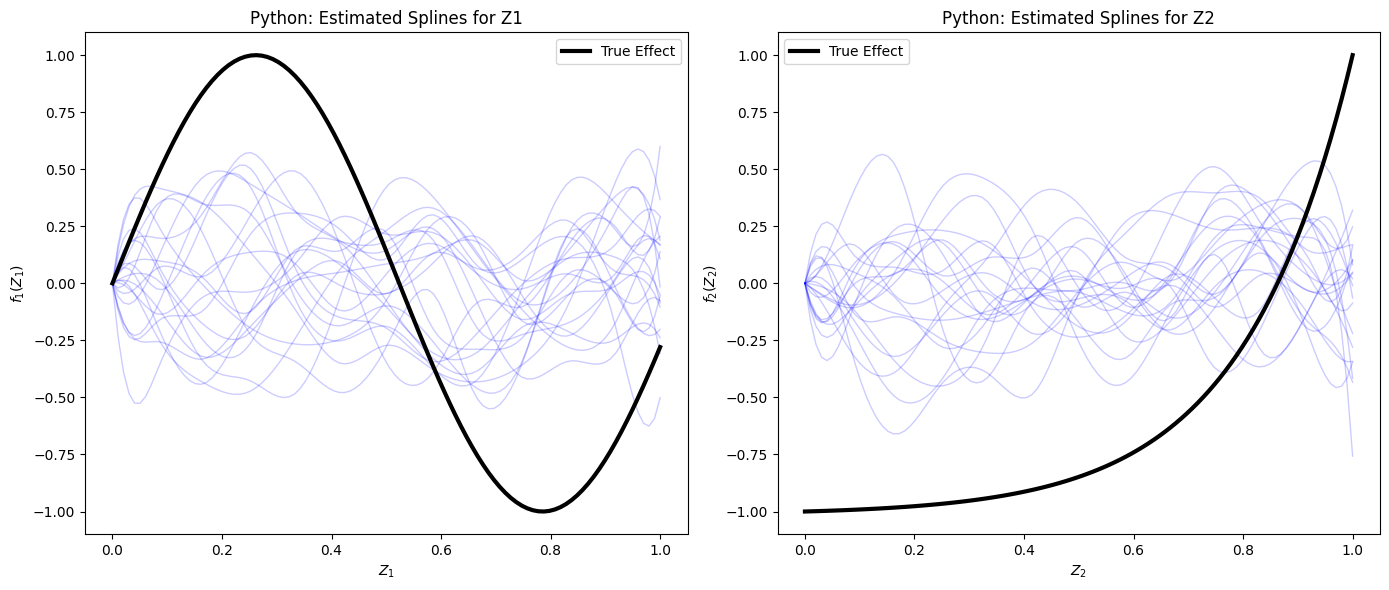

Python-only figure saved as ./outputs/python_estimated_splines.png


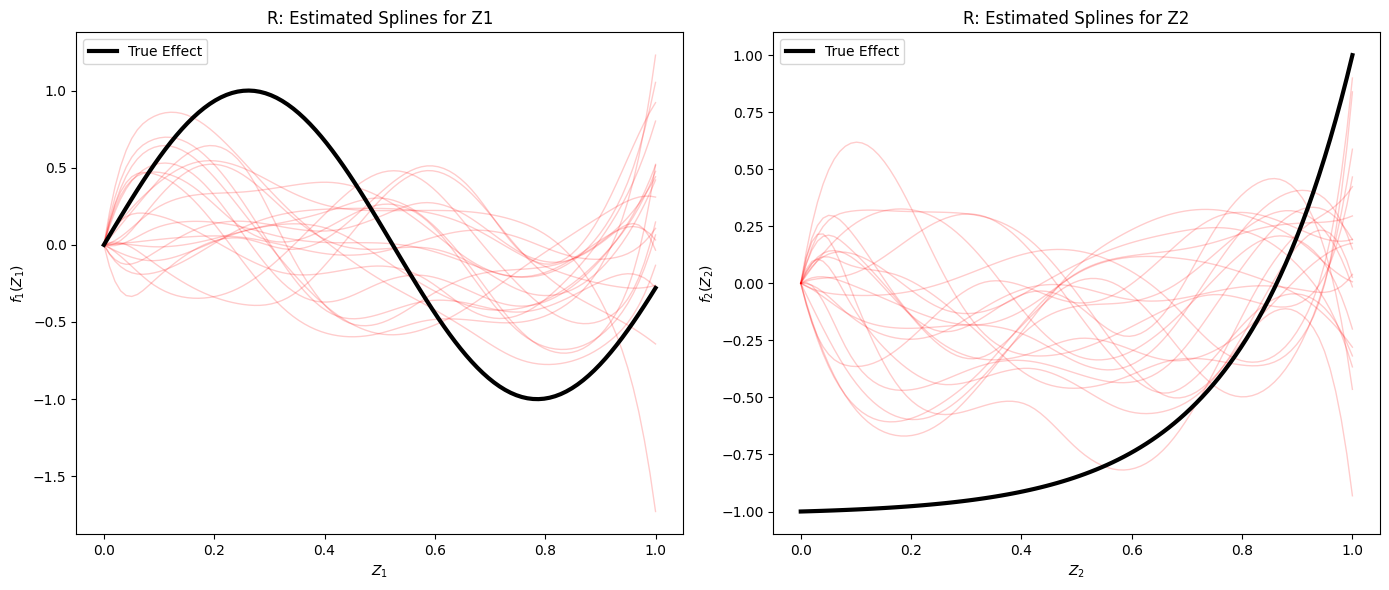

R-only figure saved as ./outputs/r_estimated_splines.png


In [60]:
# Parameters (adjust as needed)
n = 1000
n_reps = 20
d = "gaussian_homo"
snr = 1
n_knots = 10   # so that n_knots+4 equals 14
method = "point_estimates"
python_estimate_path = "./outputs/"
r_estimate_path = "../../SSDR/results/point_estimates/"
true_path = "../data_generation/output"
true_linear = {'loc': {'Intercept': 0, 'X1': 3, 'X2': -1}}

# Plot combined spline estimates
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path, combined=False, bias_reconstruct=False)



In [45]:
# # Plot combined spline estimates
# plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
#                       python_estimate_path, r_estimate_path, combined=True)

In [46]:
# # Plot combined linear boxplots
# plot_linear_boxplots(n, n_reps, d, snr, method,
#                      python_estimate_path, r_estimate_path, true_path, true_linear, combined=False)


/scratch/ipykernel_3679297/659503951.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(scale_data, patch_artist=True, widths=0.6,


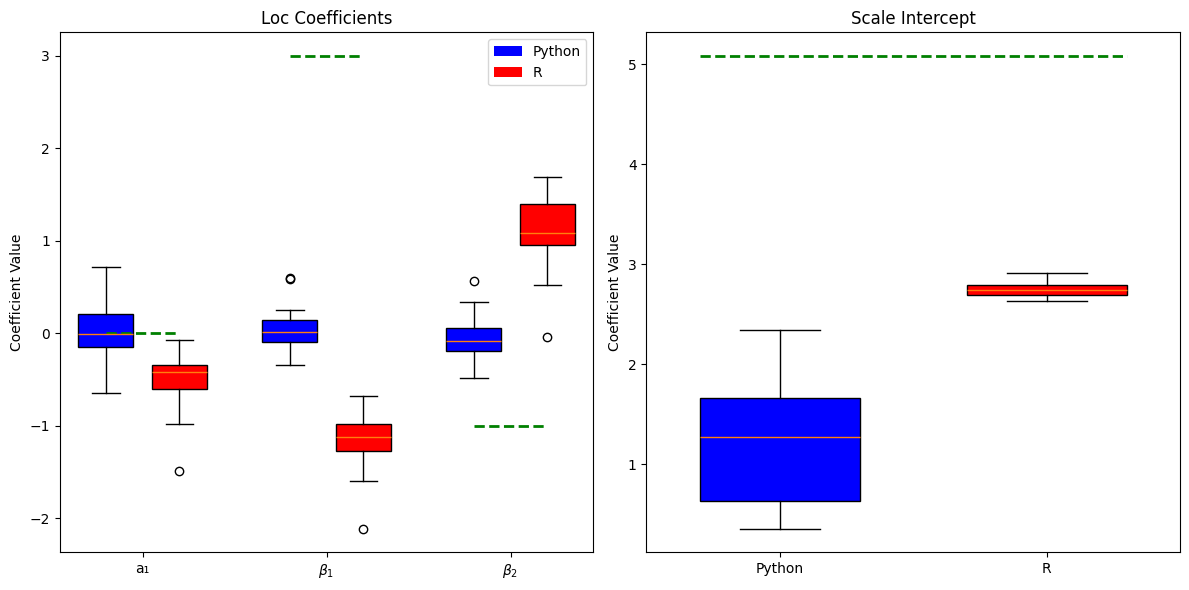

Combined linear boxplot figure saved as ./outputs/linear_boxplots_combined.png


In [40]:
# Plot combined linear boxplots
plot_linear_boxplots(n, n_reps, d, snr, method,
                     python_estimate_path, r_estimate_path, true_path, true_linear, combined=True)


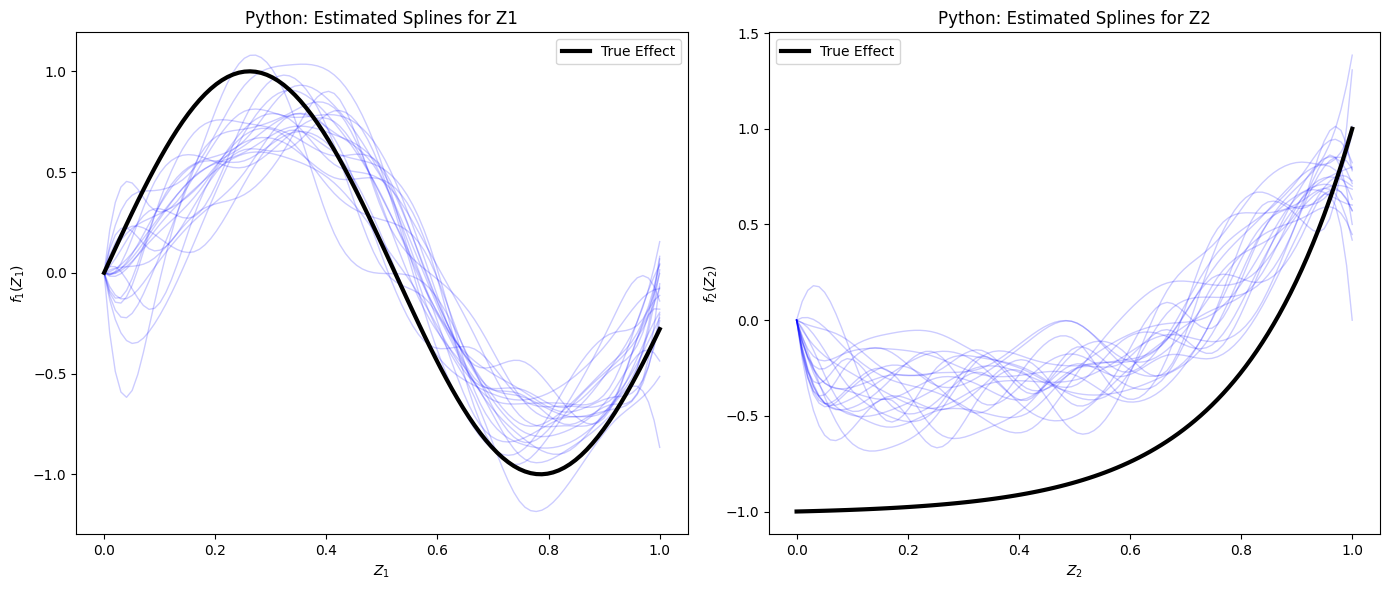

Python-only figure saved as ./outputs/python_estimated_splines.png


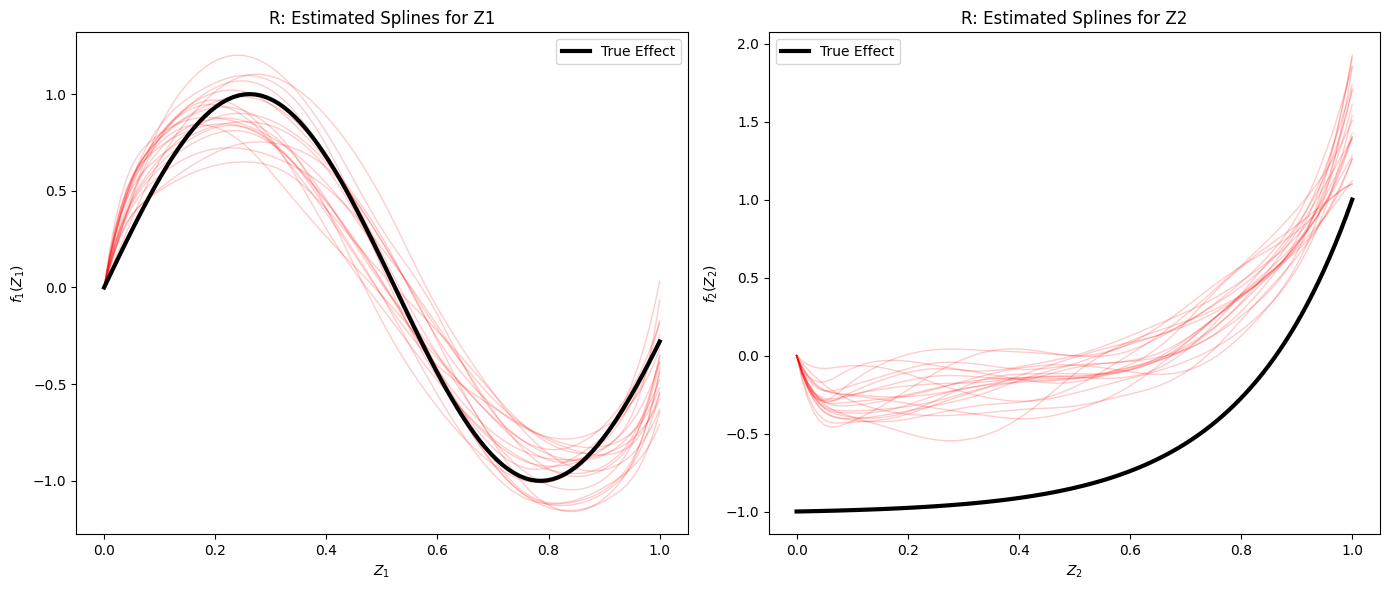

R-only figure saved as ./outputs/r_estimated_splines.png


In [61]:
# Parameters (adjust as needed)
n = 1000
n_reps = 20
d = "gaussian_homo"
snr = 8
n_knots = 10   # so that n_knots+4 equals 14
method = "point_estimates"
python_estimate_path = "./outputs/"
r_estimate_path = "../../SSDR/results/point_estimates/"
true_path = "../data_generation/output"
true_linear = {'loc': {'Intercept': 0, 'X1': 3, 'X2': -1}}

# Plot combined spline estimates
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path, combined=False)



/scratch/ipykernel_3679297/659503951.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(scale_data, patch_artist=True, widths=0.6,


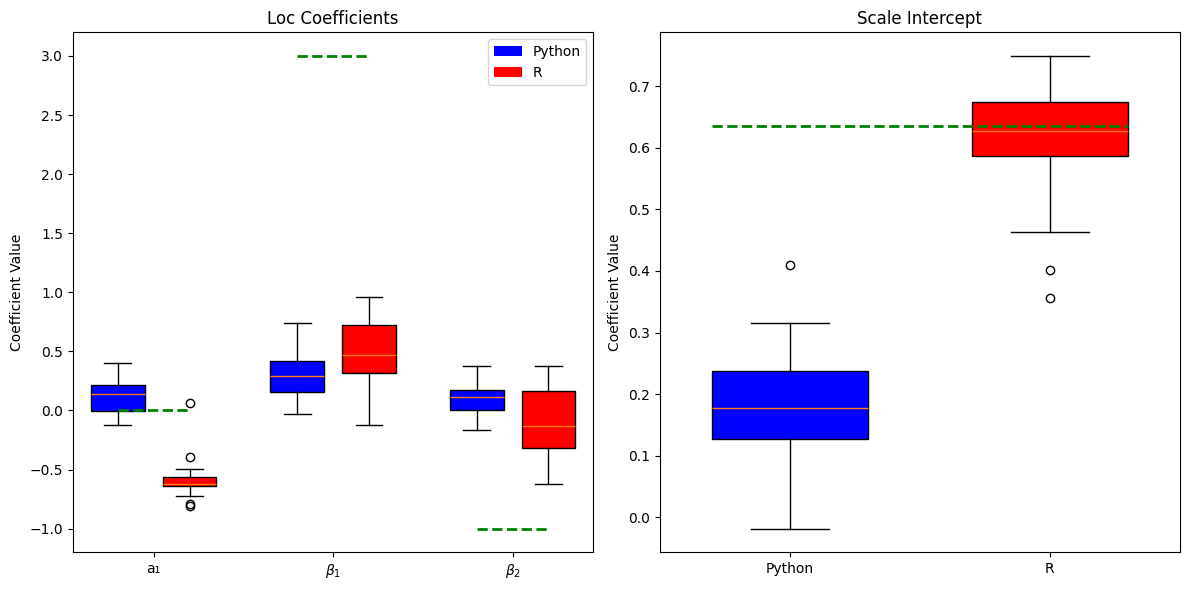

Combined linear boxplot figure saved as ./outputs/linear_boxplots_combined.png


In [44]:
# Plot combined linear boxplots
plot_linear_boxplots(n, n_reps, d, snr, method,
                     python_estimate_path, r_estimate_path, true_path, true_linear, combined=True)


/scratch/ipykernel_430247/3131575602.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(loc_data, labels=["Intercept", "X1", "X2"])
/scratch/ipykernel_430247/3131575602.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(scale_data, labels=["Estimated", "True"])


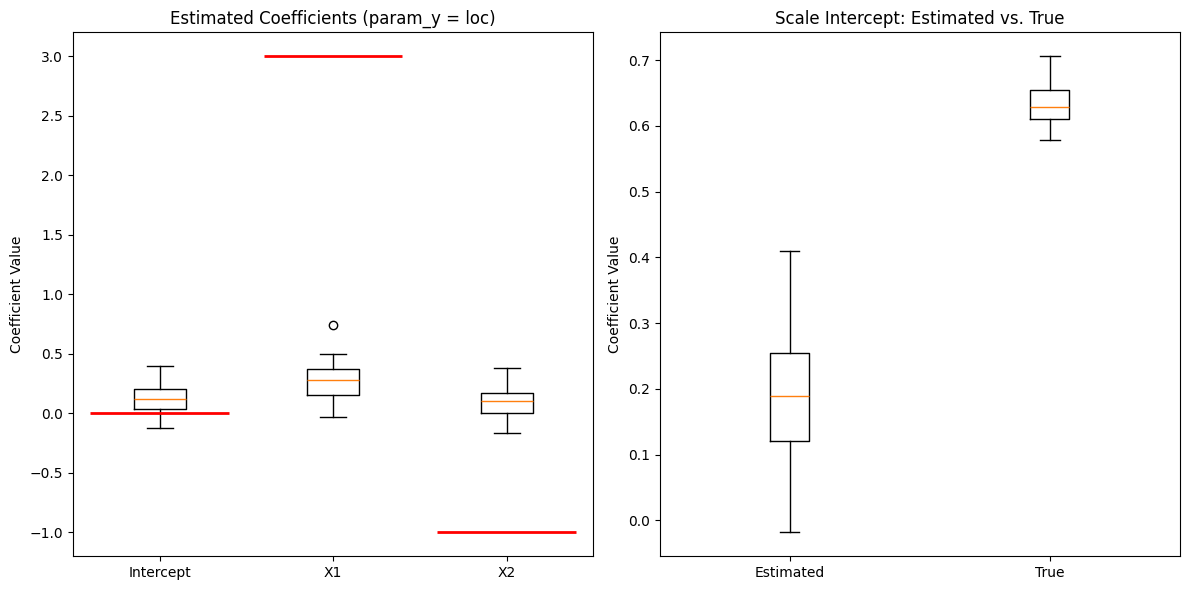

Boxplot figure saved as ./outputs/linear_boxplots.png


In [ ]:
# Parameters for data retrieval and plotting.
n = 1000
n_reps = 27   # Number of replicates (adjust as needed)
d = "gaussian_homo"
snr = 8
n_knots = 10  # so that n_knots+4 equals 14 (as in your CSV sample)
method = "point_estimates"
# Directories (adjust paths as needed)
true_path = "../data_generation/output"   # where 'a' is stored
estimate_path = "./outputs/"
true_linear = {'loc': {'Intercept': 0, 'X1': 3, 'X2': -1}}

# Call the function to produce boxplots.
plot_linear_boxplots(n, n_reps, d, snr, method, estimate_path, true_path, true_linear) # constraint? non-zero?

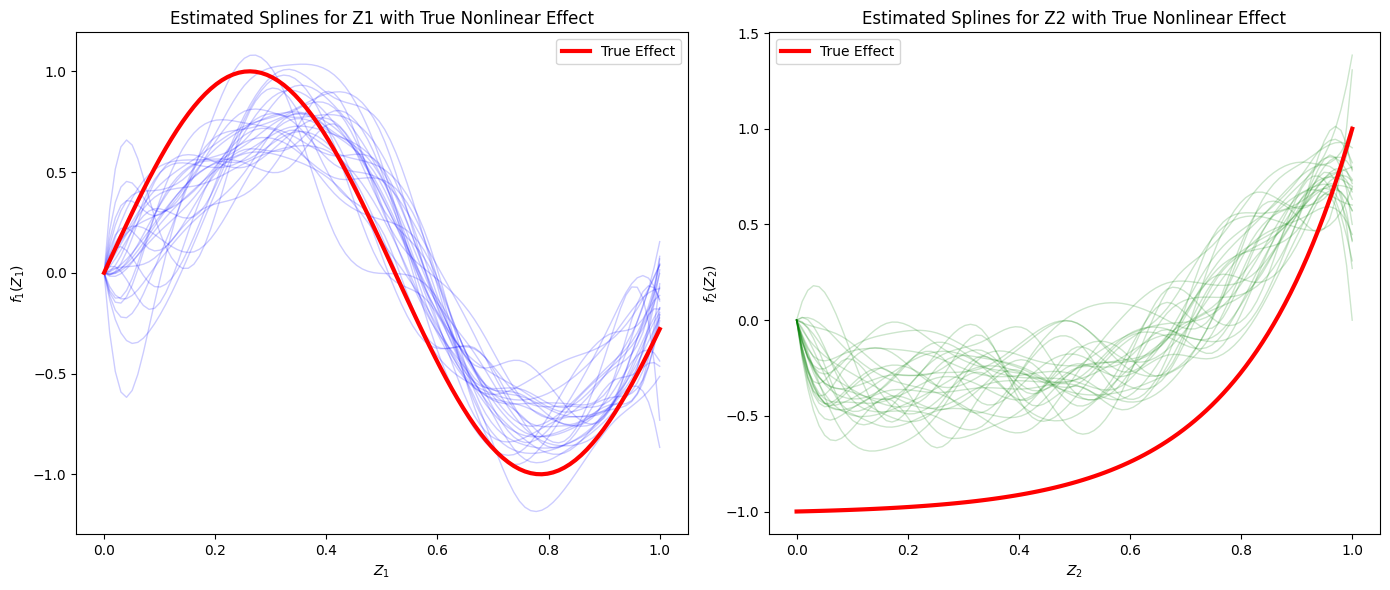

Figure saved as ./outputs/estimated_splines.png


In [ ]:
plot_spline_estimates(n, n_reps, d, snr, n_knots, method, true_path, estimate_path) # intercept

In [56]:
import pandas as pd
import re

def parse_value(x):
    """
    Parse a string like "[0.352144]" or "[ 0.39536634 -0.07990031 ... ]" 
    into a float or list of floats.
    """
    # Remove leading and trailing brackets and any extra whitespace
    x = x.strip("[]").strip()
    # Split by whitespace or comma
    parts = re.split("[,\\s]+", x)
    # Remove any empty parts
    parts = [p for p in parts if p != ""]
    if len(parts) == 0:
        return None
    elif len(parts) == 1:
        try:
            return float(parts[0])
        except ValueError:
            return parts[0]
    else:
        try:
            return [float(p) for p in parts]
        except ValueError:
            return parts

# File path to the CSV file produced by R
filename = "../../SSDR/results/point_estimates/point_estimates_n_1000_rep_0_dist_gaussian_homo_SNR_1.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(filename)

# Parse the 'value' column if needed
df['value'] = df['value'].apply(parse_value)

# Option 1: Convert the DataFrame to a dictionary of lists (each column is a key)
coef_dict = df.to_dict(orient="list")

# Option 2: Create a dictionary keyed by scenario_index and param_y, if you prefer a nested structure.
# For example:
nested_coef_dict = {}
for _, row in df.iterrows():
    scenario = row["scenario_index"]
    param_y = row["param_y"]
    param_eta = row["param_eta"]
    value = row["value"]
    if scenario not in nested_coef_dict:
        nested_coef_dict[scenario] = {}
    if param_y not in nested_coef_dict[scenario]:
        nested_coef_dict[scenario][param_y] = {}
    nested_coef_dict[scenario][param_y][param_eta] = value

# Print the dictionaries to check
print("Coefficient dictionary (flat):")
print(coef_dict)
print("\nCoefficient dictionary (nested):")
print(nested_coef_dict)


KeyError: 'value'

In [59]:
import pandas as pd

# Define the scenario_index that was used in the filename.
scenario_index = "n_1000_rep_0_dist_gaussian_homo_SNR_1"

# Construct the file path to the CSV file.
filename = f"../../SSDR/results/point_estimates/point_estimates_{scenario_index}.csv"

# Read the CSV file into a DataFrame.
df = pd.read_csv(filename)

# The CSV from R is in wide format with columns like "X1", "X2", "s.Z1..k...15..bs....cr..", etc.
# Convert (melt) the DataFrame to long format.
df_long = df.melt(var_name="param_eta", value_name="value")

# Add columns for scenario_index and param_y.
# In this example, we assume these coefficients come from the 'loc' model.
df_long["scenario_index"] = scenario_index
df_long["param_y"] = "loc"

# Reorder the columns.
df_long = df_long[["scenario_index", "param_y", "param_eta", "value"]]

# Optionally, convert to a dictionary of lists.
coef_dict = df_long.to_dict(orient="list")

print("Coefficient dictionary:")
print(coef_dict)


Coefficient dictionary:
{'scenario_index': ['n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0